In [1]:
# Install XGBoost, TensorFlow, SageMaker Python SDK and NumPy
!pip install xgboost
!pip install sagemaker
!pip install tensorflow
!pip install numpy

In [2]:
# Import all necessary libraries and packages
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost import XGBoost
from sagemaker.session import Session

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

2024-05-27 14:45:39.743563: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 14:45:42.365292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
# Load in the dataset
df= pd.read_csv('/home/ec2-user/SageMaker/diabetes-readmission-prediction/updated_diabetes_data.csv')

In [4]:
# View the data
df.head(10)

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,readmitted
0,8057670,96198543,?,Female,[80-90),6,5,17,9,?,...,No,Steady,No,No,No,No,No,Ch,Yes,>30
1,8042082,94466574,Caucasian,Male,[50-60),6,1,17,2,?,...,No,Steady,No,No,No,No,No,No,Yes,>30
2,8235036,79874631,Caucasian,Female,[60-70),6,1,17,5,?,...,No,Steady,No,No,No,No,No,Ch,Yes,>30
3,8274126,90421380,Caucasian,Female,[40-50),6,1,17,3,?,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,8421486,55628172,Caucasian,Female,[70-80),6,6,17,11,?,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,8576406,80041266,Caucasian,Female,[80-90),6,1,17,9,?,...,No,Steady,No,No,No,No,No,Ch,Yes,>30
6,8620524,93126573,Caucasian,Female,[50-60),6,1,17,6,?,...,No,No,No,No,No,No,No,No,No,>30
7,8753532,10648701,Caucasian,Male,[70-80),6,3,17,6,?,...,No,No,No,No,No,No,No,No,Yes,NO
8,8866632,103586670,Caucasian,Male,[70-80),6,1,17,6,?,...,No,Steady,No,No,No,No,No,No,Yes,>30
9,9089646,42912702,Caucasian,Female,[60-70),6,1,17,7,?,...,No,Steady,No,No,No,No,No,Ch,Yes,>30


In [5]:
# Explore the data
df.shape

(101766, 47)

In [6]:
# Explore the data
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide', 'citoglipton', 'insulin', 'glyburide_metformin',
       'glipizide_metformin', 'glimepiride_pioglitazone',
       'metformin_rosiglitazone', 'metformin_pioglitazone', 'change',
       'diabetesmed', 'readmitted'],
      dtype='object')

In [7]:
# Double check for missing values
missing_values= df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

In [8]:
# Display summary statistics for numeric columns
numeric_summary= df.describe()
print(numeric_summary)

       encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05      101766.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026403e+08  3.869636e+07           1.445403   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496119e+07  2.341322e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302709e+08  8.754595e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101766.000000        101766.000000     101766.000000   
mean                   3.715642             5.754437          4.395987   
std                    5.280166             4.064081          2.985108   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             1.000000          2.000000   
50%                    1.000000             7.00000

In [9]:
# Display summary statistics for categorical columns
categorical_summary= df.describe(include= [object])
print(categorical_summary)

             race  gender      age payer_code medical_specialty  diag_1  \
count      101766  101766   101766     101766            101766  101766   
unique          6       3       10         18                73     717   
top     Caucasian  Female  [70-80)          ?                 ?     428   
freq        76099   54708    26068      40256             49949    6862   

        diag_2  diag_3 metformin repaglinide  ... citoglipton insulin  \
count   101766  101766    101766      101766  ...      101766  101766   
unique     749     790         4           4  ...           1       4   
top        276     250        No          No  ...          No      No   
freq      6752   11555     81778      100227  ...      101766   47383   

       glyburide_metformin glipizide_metformin glimepiride_pioglitazone  \
count               101766              101766                   101766   
unique                   4                   2                        2   
top                     No       

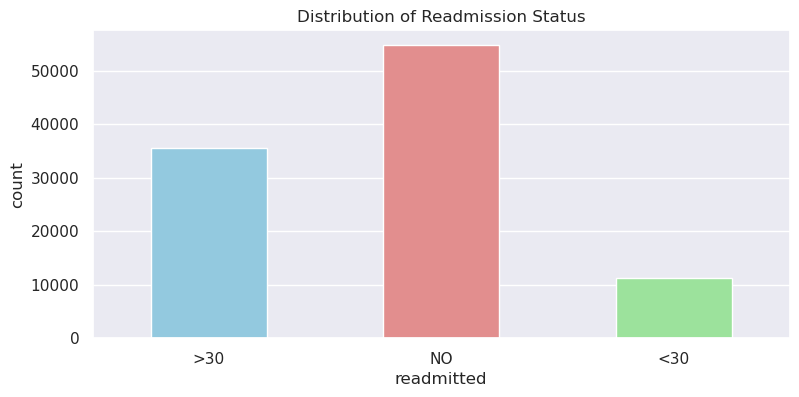

In [67]:
# Define a color palette 
palette = ["skyblue", "lightcoral", "lightgreen"] 

# Distribution of target feature (readmitted)
plt.figure(figsize= (9,4))
sns.countplot(data= df, x= 'readmitted', width= 0.5, palette= palette)
plt.title('Distribution of Readmission Status')
plt.show()

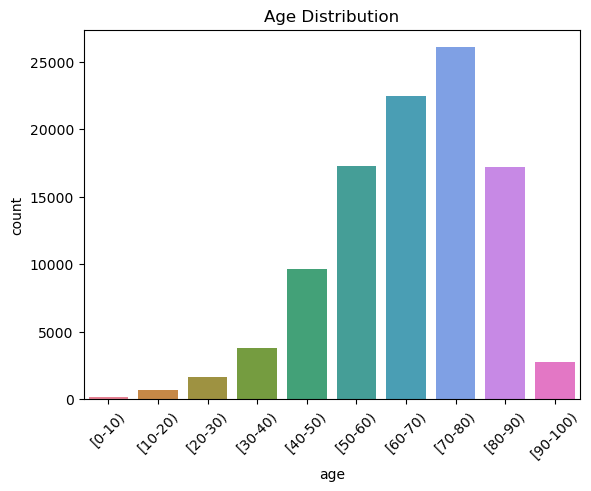

In [53]:
# Define a color palette 
palette= sns.color_palette("husl", len(age_order))

# Define the order of the age categories
age_order= ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']

# Distribution of Age
sns.countplot(data= df, x= 'age', order= age_order, palette= palette)
plt.title('Age Distribution')
plt.xticks(rotation= 45)
plt.show()

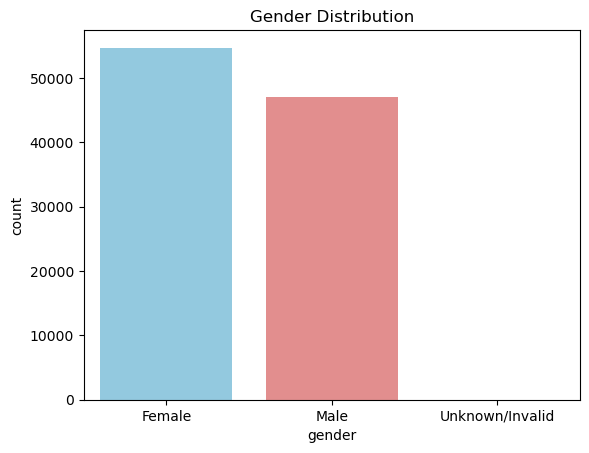

In [54]:
# Define a color palette 
palette= ["skyblue", "lightcoral"] 

# Distribution of Gender
sns.countplot(data= df, x= 'gender', palette= palette)
plt.title('Gender Distribution')
plt.show()

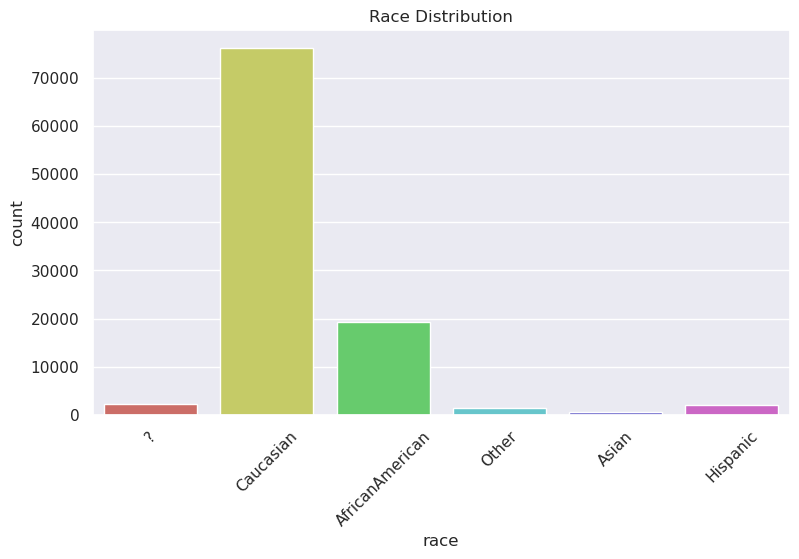

In [64]:
# Define a color palette 
palette= sns.color_palette("hls", df['race'].nunique())

# Race Distribution
plt.figure(figsize= (9,5))
sns.countplot(data= df, x= 'race', palette= palette)
plt.title('Race Distribution')
plt.xticks(rotation= 45)
plt.show()

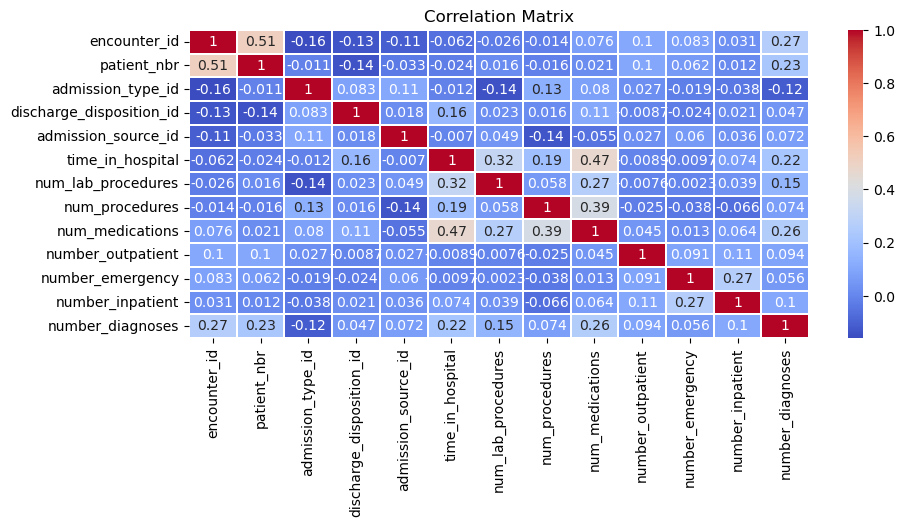

In [56]:
# Select only numeric columns for correlation matrix
numeric_df= df.select_dtypes(include= ['number'])

# Heatmap of correlations of numeric features
plt.figure(figsize= (10,4))
correlation_matrix= numeric_df.corr()
sns.heatmap(correlation_matrix, annot= True, cmap= 'coolwarm', linewidths= 0.2)
plt.title('Correlation Matrix')
plt.show()

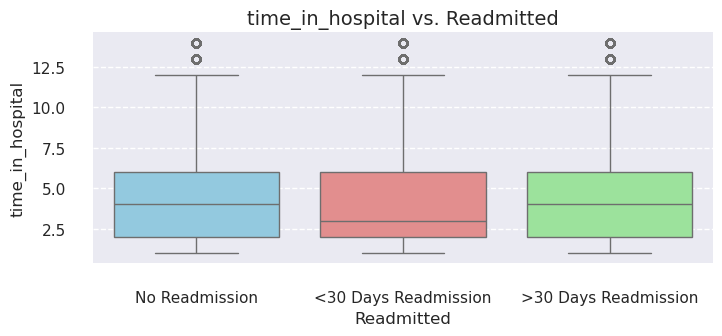

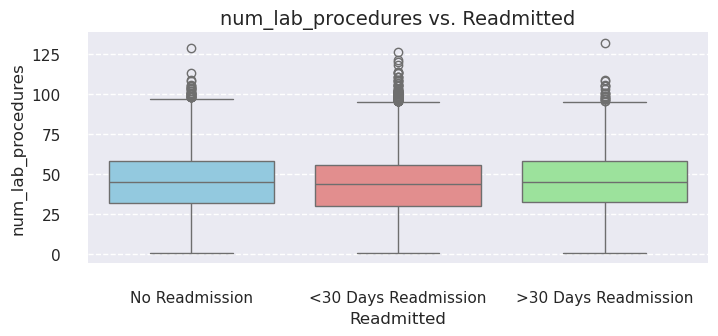

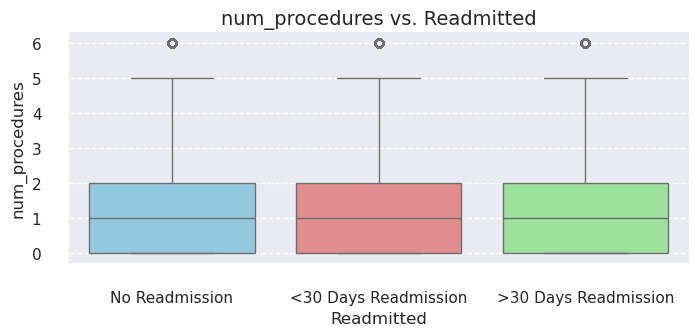

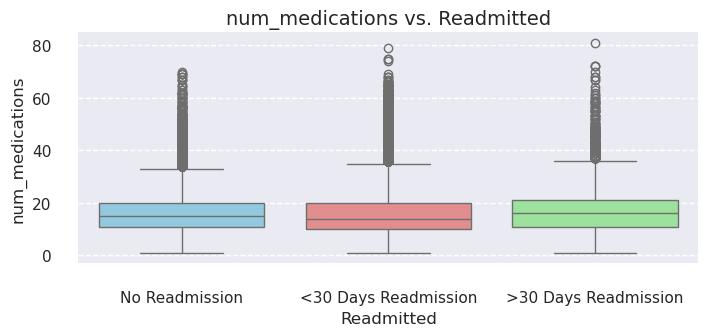

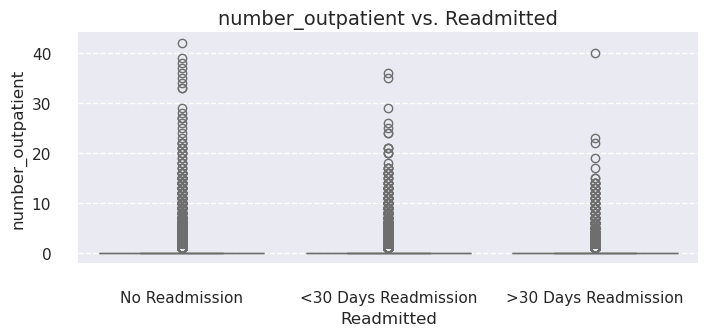

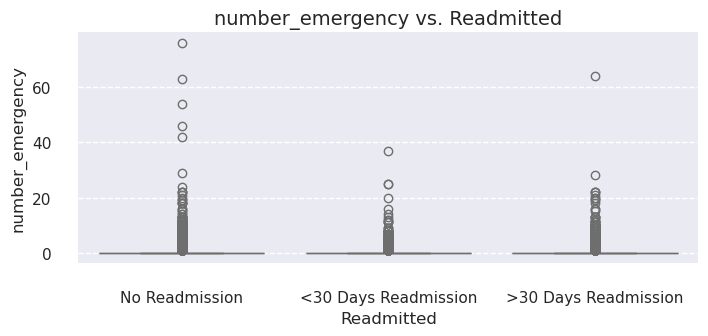

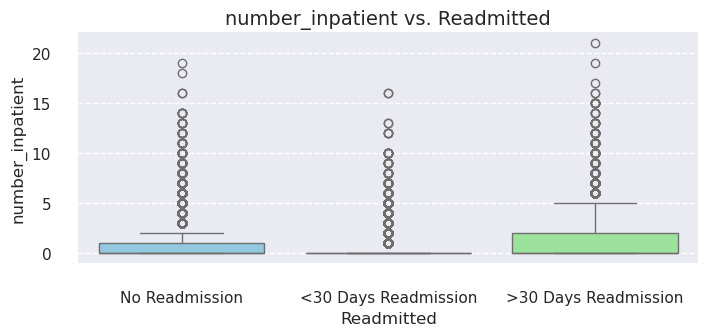

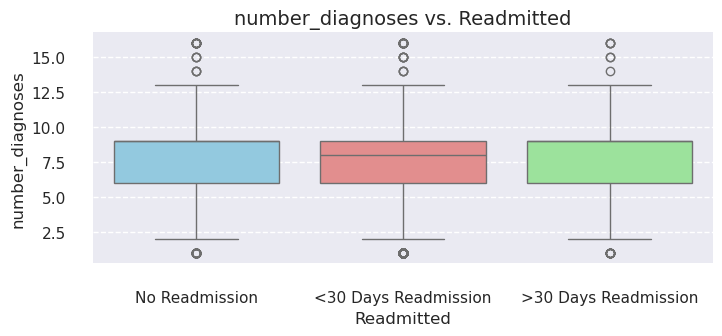

In [59]:
# Boxplot for numeric features vs. 'readmitted'
numeric_columns= ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                  'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

# Define theme 
sns.set_theme(style="darkgrid")

# Define a color palette for the readmitted categories
palette = ["skyblue", "lightcoral", "lightgreen"]

for col in numeric_columns:
    plt.figure(figsize=(8,3))  
    ax = sns.boxplot(data=df, x='readmitted', y=col, palette=palette)  
    plt.title(f'{col} vs. Readmitted', fontsize=14)
    plt.xlabel('Readmitted', fontsize=12)
    plt.ylabel(col, fontsize=12)
    ax.set_xticklabels(['No Readmission', '<30 Days Readmission', '>30 Days Readmission'], fontsize=10)
    sns.despine(offset=10, trim=True)  
    
    # Add a horizontal grid (optional)
    plt.grid(axis='y', linestyle='--')
    
    plt.show()

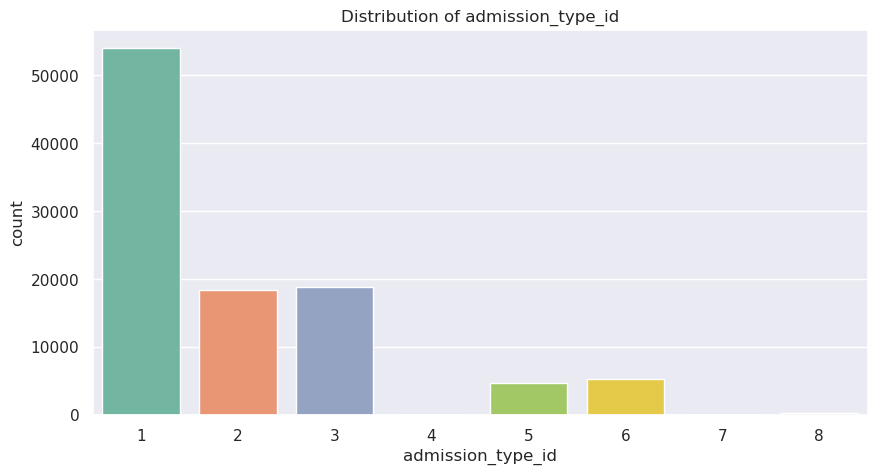

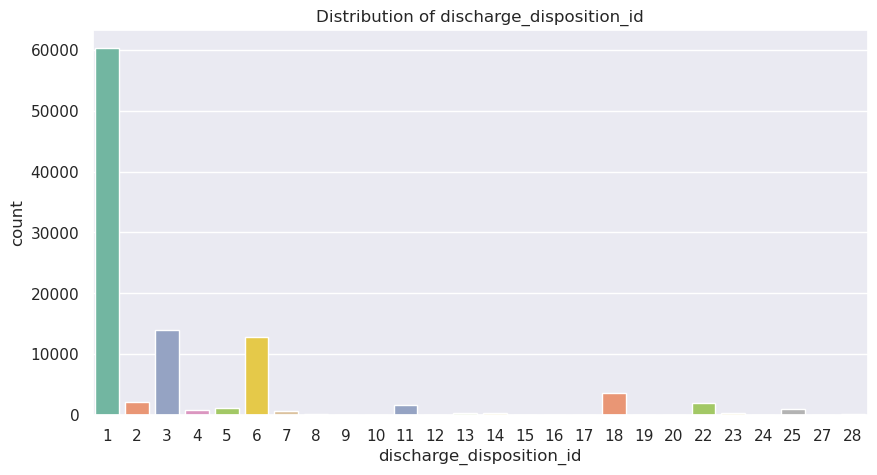

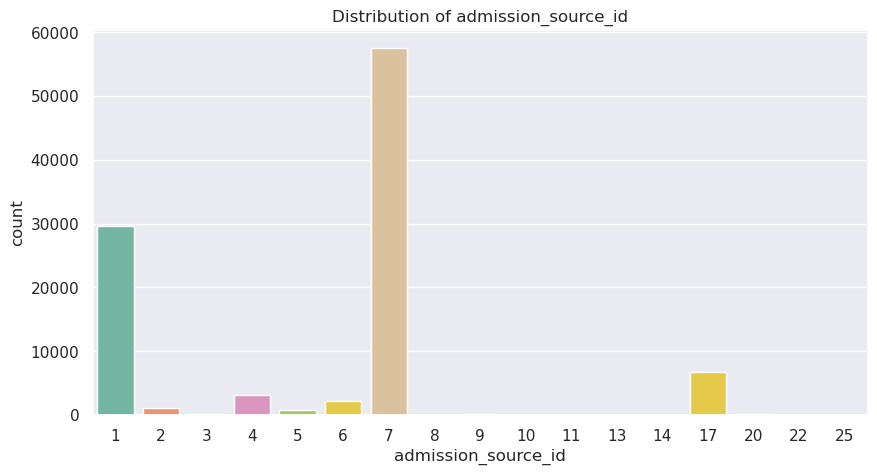

In [60]:
# Distribution of admission type, discharge disposition and admission source
cat_columns= ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

for col in cat_columns:
    plt.figure(figsize= (10,5))
    sns.countplot(data= df, x= col, palette= 'Set2')
    plt.title(f'Distribution of {col}')
    plt.show()

In [17]:
# Define categorical and numerical columns
categorical_features= ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
numerical_features= ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

In [38]:
# Apply transformations
X = df.drop('readmitted', axis=1)
y = df['readmitted']

In [41]:
# Label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Now split the data with the encoded labels
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [42]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

In [43]:
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.1, 0.01], 'max_depth': [3, 5],
                         'n_estimators': [50, 100], 'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [44]:
# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best accuracy found:  0.5866457364359384


In [45]:
# Evaluate the model with the best found parameters
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Print the evaluation metrics
print("XGBoost Accuracy", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

XGBoost Accuracy 0.5834484876401044
              precision    recall  f1-score   support

           0       0.49      0.02      0.05      1481
           1       0.50      0.36      0.42      4511
           2       0.61      0.84      0.71      7034

    accuracy                           0.58     13026
   macro avg       0.53      0.41      0.39     13026
weighted avg       0.56      0.58      0.53     13026



In [68]:
# Build a nueral network
model=  Sequential()

# Network layers
model.add(Dense(64, input_dim= X_train.shape[1], activation= 'relu'))
model.add(Dense(32, activation= 'relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation= 'softmax'))

In [69]:
# Train the model
model.compile(loss= 'sparse_categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
nn= model.fit(X_train, y_train, epochs= 50, batch_size= 32, validation_data=(X_test, y_test))

Epoch 1/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5230 - loss: 1.2122 - val_accuracy: 0.5643 - val_loss: 0.9055
Epoch 2/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5651 - loss: 0.9089 - val_accuracy: 0.5673 - val_loss: 0.8959
Epoch 3/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5727 - loss: 0.8983 - val_accuracy: 0.5755 - val_loss: 0.8926
Epoch 4/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5764 - loss: 0.8905 - val_accuracy: 0.5702 - val_loss: 0.8885
Epoch 5/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5786 - loss: 0.8870 - val_accuracy: 0.5729 - val_loss: 0.8897
Epoch 6/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5804 - loss: 0.8887 - val_accuracy: 0.5744 - val_loss: 0.8828
Epoch 7/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5763 - loss: 0.8839 - val_accuracy: 0.5729 - val_loss: 0.8930
Epoch 8/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5811 - loss: 0.8847 - 

In [76]:
# Evaluate the model
_, accuracy= model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.5723 - loss: 0.9013
Accuracy: 0.58


In [72]:
# Predict on the test set
y_pred_proba= model.predict(X_test)

# Get predicted class labels
y_pred_classes= y_pred_proba.argmax(axis= -1)

408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


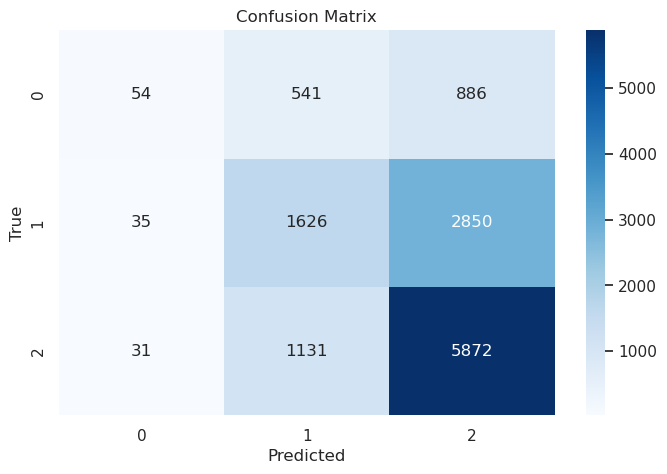

In [74]:
# Confusion Matrix
cm= confusion_matrix(y_test, y_pred_classes)

# Plot confusion Matrix
plt.figure(figsize= (8,5))
sns.heatmap(cm, annot= True, fmt= 'd', cmap= 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [77]:
# Classification Report
print('Classification Report:\n', classification_report(y_test, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.04      0.07      1481
           1       0.49      0.36      0.42      4511
           2       0.61      0.83      0.71      7034

    accuracy                           0.58     13026
   macro avg       0.52      0.41      0.40     13026
weighted avg       0.55      0.58      0.53     13026

